## Notebook demonstrating how to create an SDK wrapper around an API endpoint

We will be using the St. Louis Fed API for economic data. 

Link to the FRED website: https://fred.stlouisfed.org/


We will be creating a wrapper around the "fred/series/observations" endpoint. The documentation of how this endpoint works is here: 
https://fred.stlouisfed.org/docs/api/fred/series_observations.html


First we write the class, which will be the wrapper around the API

In [94]:
import requests # Will be using the request library to make the web request.
import pandas as pd # Will be using pandas to have a data table summary of the data.
import matplotlib.pyplot as plt # Will be using matplotlib just to visualize the series.


# FredPy class is the wrapper around the API endpoint. You can think of this as an SDK. 
class FredPy:

    # Constructor method (initializes the properties of the object).
    def __init__(self, token=None):
        self.token=token

        # this is the API endpoint we are hitting.
        self.endpoint = "https://api.stlouisfed.org/fred/series/observations" 

        # these are the parameters we pass to the API to tell it what we are asking it for.
        self.querystring = "?series_id={seriesID}&api_key={key}&file_type=json" + \
                            "&observation_start={start_date}&observation_end={end_date}&units={units}"

        # construct the final URL to make the web request to.
        self.url = self.endpoint + self.querystring


    # Method to set the token.
    def set_token(self, token):
        self.token=token

    # The main 'get series' method to actually fetch the series through the web. 
    def get_series(self, seriesID, start_date, end_date, units):
        # The series start_date and end_date should be in yyyy-mm-dd format. 

        # If the token was set, make the web request.
        if(self.token):
            # Make the web request.
            response = requests.get(
                self.url.format(seriesID=seriesID, key=self.token, start_date=start_date, end_date=end_date, units=units)
            )

            # Handle the response.
            if(response.status_code == 200):
                series_data = pd.DataFrame(response.json()['observations'])[['date', 'value']]\
                                .assign(date = lambda cols: pd.to_datetime(cols['date']))\
                                .assign(value = lambda cols: cols['value'].astype(float))\
                                .rename(columns = {'value': seriesID})
                return series_data

            else:
                raise Exception("Error in making GET request, returned status code = {}.".format(response.status_code))

        else:
            # Raise exception when you try to get the series but the token was not yet set. 
            raise Exception("Token is was not specified.")




Second we get the API token from the website

In [95]:
# Specify the token
my_token = "cbf1882aeb32943dc6a1ad50ceb1502a"

Third, we try to use the SDK to fetch some data from the FRED API

In [96]:
# Instantiate the FredPy object
fredpy = FredPy()

# Set the token
fredpy.set_token(my_token)

# Test getting the GDP series
GDP_data = fredpy.get_series(
    seriesID = 'GDP', 
    start_date = "2015-01-01", 
    end_date = "2021-12-01",
    units="pc1"
)

# Preview the data series
GDP_data

,date,GDP
0,2015-01-01,4.94081
1,2015-04-01,4.18609
2,2015-07-01,3.17717
3,2015-10-01,2.68611
4,2016-01-01,2.41204
5,2016-04-01,2.29700
6,2016-07-01,2.55913
7,2016-10-01,3.46912
8,2017-01-01,3.95438
9,2017-04-01,3.82182


Grab another series from the FRED API

In [97]:
# Test getting the unemployment rate series
unemployment_rate_data = fredpy.get_series(
    seriesID = 'UNRATE', 
    start_date = "2015-01-01", 
    end_date = "2021-12-01",
    units="lin"
)

# Preview the data series
unemployment_rate_data

,date,UNRATE
0,2015-01-01,5.7
1,2015-02-01,5.5
2,2015-03-01,5.4
3,2015-04-01,5.4
4,2015-05-01,5.6
...,...,...
79,2021-08-01,5.2
80,2021-09-01,4.7
81,2021-10-01,4.6
82,2021-11-01,4.2


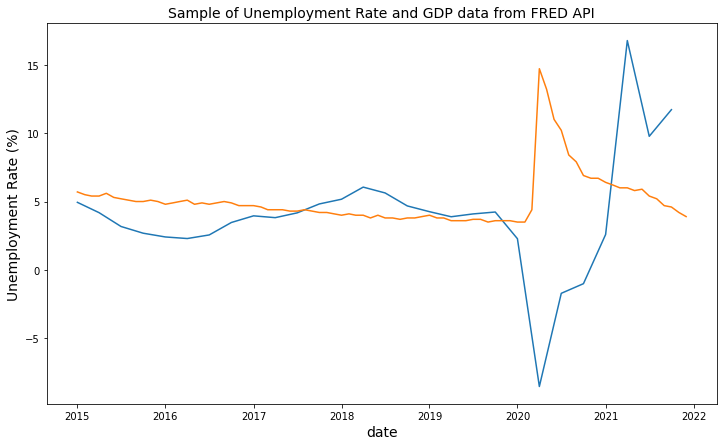

In [98]:
# Visualize the data graphically
plt.figure(figsize=(12, 7))
plt.plot(pd.to_datetime(GDP_data['date']), GDP_data['GDP'].astype(float))
plt.plot(pd.to_datetime(unemployment_rate_data['date']), unemployment_rate_data['UNRATE'].astype(float))
plt.xlabel('date', fontsize=14)
plt.ylabel('Unemployment Rate (%)', fontsize=14)
plt.title('Sample of Unemployment Rate and GDP data from FRED API', fontsize=14)
plt.legend()
plt.show()

Finally we can test some errors

In [99]:
# Test if the token is specified but wrong. 
fredpy.set_token("this is a bad API token/key")

GDP_data = fredpy.get_series(
    seriesID = 'GDP', 
    start_date = "2015-01-01", 
    end_date = "2021-12-01",
    units="pc1"
)

Exception: Error in making GET request, returned status code = 400.

In [ ]:
# Test if the token is not specified
fredpy2 = FredPy()

GDP_data = fredpy2.get_series(
    seriesID = 'GDP', 
    start_date = "2015-01-01", 
    end_date = "2021-12-01",
    units="pc1"
)

Exception: Token is incorrect or was not specified.